코드 공유 및 EDA를 통해 확인한 것
- 결측치 X
- 레이블 0:1비율 = 2564:2436
- 문자(char) 15~45개 사이에 분포, 문자 길이 짧을수록 데이터 많아짐
- 4~6개의 단어(word)로 이루어진 데이터가 많음
- TF-IDF와 CountVectorizer 비슷

ps. 해당 대회에 앞선 코드 공유를 참고하였습니다. 코드 공유 감사드립니다.
- '박이삭'님의 [단어 수준의 EDA 진행해보았습니다](https://dacon.io/competitions/official/235864/codeshare/4126?page=1&dtype=recent)
- 'hahaha'님의 [tfidf and Simple-Dense-Layer](https://dacon.io/competitions/official/235864/codeshare/4144?page=1&dtype=recent)
- '하지'님의 [EDA](https://dacon.io/competitions/official/235864/codeshare/4145?page=1&dtype=recent)
- '베이스라인'님의 [Colab에서 경진대회 데이터셋 쉽게 다운로드](https://dacon.io/competitions/official/235864/codeshare/4148?page=1&dtype=recent)

주요 참고 자료
- [네이버 영화 리뷰 감정 분류하기](https://wikidocs.net/44249)

In [ ]:
!pip install gdrive_dataset

from gdrivedataset import loader

file_id = "1IbyL1762M0Lgoq7_qm2RaXfl3ney0e9i"
loader.load_from_google_drive(file_id)

========== files ============

data/dataset



In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 17.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path as osp
from konlpy.tag import Okt
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# pd.set_option('display.max_rows', None)

In [ ]:
data_dir = 'data/dataset'

train = pd.read_csv(osp.join(data_dir, "train.csv"))
test = pd.read_csv(osp.join(data_dir, "test.csv"))
sub = pd.read_csv(osp.join(data_dir, "sample_submission.csv"))

train.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0


#### cf. 정규표현식 전처리

* 숫자 : '원작 읽어보면 1점도 아깝다.' 등 숫자를 제외해도 '아깝다' 등 의 부정/긍정 단어가 포함되어 있어서 제거했습니다.
* 완전하지 않은 한글 : 'ㅠㅠ','ㅋㅋ' 같은 완전한 한글 표현은 아니지만 감성 분류에 있어서 중요한 지표가 될 수 있을 것 같아 남겨두었습니다.
* 영어 : 'very very good' 같이 긍정/부정으로 해석될 수 있어서 남겨두었습니다.

In [ ]:
def preprocess(text):
  text = re.sub(r"[^A-Za-zㄱ-ㅎㅏ-ㅣ가-힣 ]","", text) # 영어,한글만 포함
  return text

train['preproc'] = train.document.apply(lambda x : preprocess(x))
test['preproc'] = test.document.apply(lambda x : preprocess(x))

train.head()

,id,document,label,preproc
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1,괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0,아무래도 년도지난작품이라 지금보기는너무유치하다
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0,지금까지의 영화들이 그랬듯 이 영화역시 일본에 대한 미화는 여전하다


In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()
X_train = []
for sentence in train['preproc']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

X_test = []
for sentence in test['preproc']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

print(X_train[:3])

[['영상', '이나', '음악', '이쁘다', '해도', '미화', '시키다', '불륜', '일', '뿐'], ['히치콕', '영화', '보다', '분명', '박수', '치다'], ['괜찮다', '음악', '영화', '또', '나오다', '따뜻하다', '겨울', '되다', '것', '같다']]


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6767
등장 빈도가 1번 이하인 희귀 단어의 수: 3704
단어 집합에서 희귀 단어의 비율: 54.73621989064578
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.914346225120935


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 3064


In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:3])

[[256, 192, 181, 238, 625, 938, 330, 939, 196, 153], [2030, 1, 2, 752, 940, 381], [148, 181, 1, 116, 25, 218, 1573, 16, 30, 21]]


In [ ]:
y_train = train['label']

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
print(len(X_train), len(y_train))
for index in drop_train:
    del X_train[index]
    del y_train[index]
y_train = np.array(y_train)
print(len(X_train), len(y_train))

5000 5000
4997 4997


리뷰의 최대 길이 : 20
리뷰의 평균 길이 : 7.57134280568341


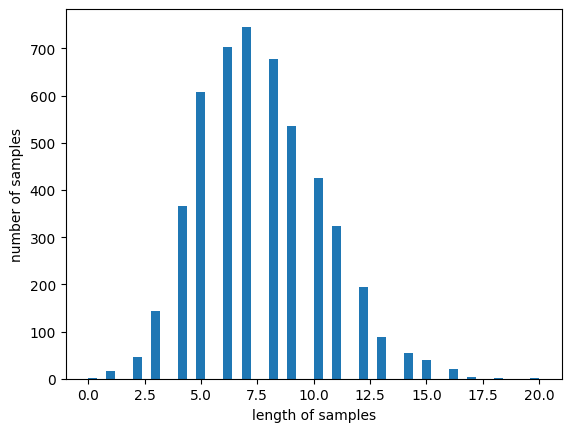

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 12
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 12 이하인 샘플의 비율: 95.7574544726836


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
61/63 [============================>.] - ETA: 0s - loss: 0.6384 - acc: 0.6588
Epoch 1: val_acc improved from -inf to 0.79200, saving model to best_model.h5
63/63 [==============================] - 5s 37ms/step - loss: 0.6341 - acc: 0.6640 - val_loss: 0.4754 - val_acc: 0.7920
Epoch 2/15
 5/63 [=>............................] - ETA: 1s - loss: 0.4644 - acc: 0.7844

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - ETA: 0s - loss: 0.3758 - acc: 0.8436
Epoch 2: val_acc improved from 0.79200 to 0.83300, saving model to best_model.h5
63/63 [==============================] - 2s 29ms/step - loss: 0.3758 - acc: 0.8436 - val_loss: 0.3602 - val_acc: 0.8330
Epoch 3/15
62/63 [============================>.] - ETA: 0s - loss: 0.2435 - acc: 0.9083
Epoch 3: val_acc improved from 0.83300 to 0.85000, saving model to best_model.h5
63/63 [==============================] - 3s 52ms/step - loss: 0.2429 - acc: 0.9084 - val_loss: 0.3359 - val_acc: 0.8500
Epoch 4/15
62/63 [============================>.] - ETA: 0s - loss: 0.1821 - acc: 0.9325
Epoch 4: val_acc improved from 0.85000 to 0.85100, saving model to best_model.h5
63/63 [==============================] - 3s 42ms/step - loss: 0.1820 - acc: 0.9324 - val_loss: 0.3462 - val_acc: 0.8510
Epoch 5/15
63/63 [==============================] - ETA: 0s - loss: 0.1397 - acc: 0.9517
Epoch 5: val_acc improved from 0.85100 to 0.85200, s

157/157 [==============================] - 1s 6ms/step


(array([1515.,  201.,  171.,  110.,   88.,   78.,   76.,   87.,   66.,
          74.,   58.,   60.,   54.,   79.,   98.,   90.,  118.,  147.,
         271., 1559.]),
 array([2.12679333e-06, 5.00016734e-02, 1.00001223e-01, 1.50000766e-01,
        2.00000316e-01, 2.49999866e-01, 2.99999416e-01, 3.49998951e-01,
        3.99998516e-01, 4.49998051e-01, 4.99997616e-01, 5.49997151e-01,
        5.99996686e-01, 6.49996221e-01, 6.99995816e-01, 7.49995351e-01,
        7.99994886e-01, 8.49994421e-01, 8.99994016e-01, 9.49993551e-01,
        9.99993086e-01]),
 <BarContainer object of 20 artists>)

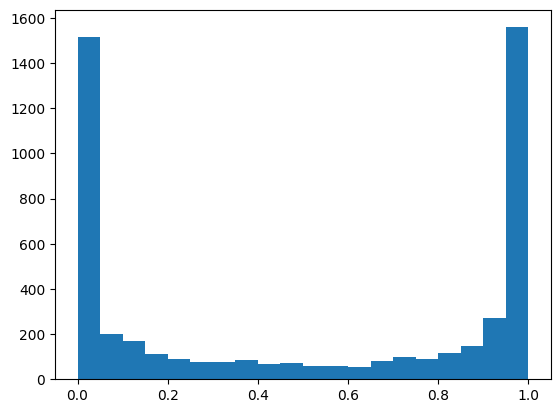

In [ ]:
loaded_model = load_model('best_model.h5')
pred = loaded_model.predict(X_test)
plt.hist(pred, bins=20)

In [ ]:
sub

,id,label
0,1,0
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
4995,4996,0
4996,4997,0
4997,4998,1
4998,4999,0


In [ ]:
result = [0 if val < 0.5 else 1 for val in pred]
sub['label'] = result
sub.to_csv("baseline.csv", index=False) # 0.848